In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.append("..")

from cybb_mist.path_conf import interim_data_dir, processed_data_dir
from tqdm.auto import tqdm
import pandas as pd
from functional import seq
from cybb_mist.trigger_mapping import parse_trigger_series


## joining `df_trigger_tot` with `df_rr`

In [3]:
import hrvanalysis

In [23]:
r_list = []
for pqt in tqdm(sorted(list(interim_data_dir.rglob("*/SCL_*.parquet")))):
    try:
        patient_id = pqt.parent.name
        condition = pqt.name.split(".")[0].split("_")[-1]
        df_trigger = parse_trigger_series(pd.read_parquet(pqt)["trigger"])
        df_trigger["patient_id"] = patient_id
        df_trigger["condition"] = condition
        df_trigger["duration"] = df_trigger["t_end"] - df_trigger["t_start"]
        df_trigger["duration_s"] = df_trigger["duration"].dt.total_seconds()
        df_trigger = df_trigger.dropna().drop_duplicates(
            subset=["trigger"], keep="first"
        )

        p = list(processed_data_dir.joinpath(patient_id).glob(f"*{condition}.parquet"))
        if not len(p):
            print(f"skipping user: {patient_id} - no df_rr")
            continue
        df_rr = pd.read_parquet(p[0])

        min_r_peak_agreement_threshold = 0.5

        for _, r in df_trigger.iterrows():
            if r.duration_s + 10 < 300:
                print(
                    f"skipping slice:{r.patient_id} - {r.trigger} - duration ({r.duration}) too short"
                )
                continue

            slc = df_rr[r.t_start : r.t_start + pd.Timedelta(minutes=5)]
            # do not use slices with lower
            mean_r_peak_agreement = slc["r_peak_agreement"].mean()

            rrs = hrvanalysis.remove_outliers(slc["RR_interval_ms"].dropna().values, verbose=False)

            if mean_r_peak_agreement < min_r_peak_agreement_threshold or len(rrs) < 300:
                print(len(slc), len(slc.RR_interval_ms.dropna()),len(rrs))
                print(
                    f"skipping slice user - {r.patient_id} - {r.trigger} - {len(slc)} - {mean_r_peak_agreement}"
                )
                continue

            r_list.append(
                pd.concat(
                    [
                        r,
                        pd.Series(hrvanalysis.get_time_domain_features(rrs)),
                        pd.Series(hrvanalysis.get_frequency_domain_features(rrs))
                    ]
                )
            )

    except Exception as e:
        print(e)

    # break


  0%|          | 0/124 [00:00<?, ?it/s]

454 17 17
skipping slice user - 1 - Start rest baseline (eyes closed) - 454 - 0.5196035242290749
456 159 159
skipping slice user - 1 - Start rest stress (eyes open) - 456 - 0.6655701754385965
484 45 45
skipping slice user - 10 - Start rest baseline (eyes closed) - 484 - 0.5432851239669422
469 232 232
skipping slice user - 10 - Start rest stress (eyes open) - 469 - 0.7787846481876333
434 13 13
skipping slice user - 10 - Start rest baseline (eyes closed) - 434 - 0.5165898617511521
415 141 141
skipping slice user - 10 - Start rest stress (eyes open) - 415 - 0.6730120481927709
347 79 79
skipping slice user - 11 - Start rest baseline (eyes closed) - 347 - 0.60835734870317
357 128 128
skipping slice user - 11 - Start rest stress (eyes open) - 357 - 0.680672268907563
402 0 0
skipping slice user - 11 - Start rest baseline (eyes closed) - 402 - 0.5
410 172 172
skipping slice user - 11 - Start rest stress (eyes open) - 410 - 0.7081707317073171
431 21 21
skipping slice user - 12 - Start rest base

In [24]:
df_feat = pd.concat(r_list, axis=1).T

## Analyzing `df_feat`

In [26]:
import seaborn as sns

sns.set_context("talk")


In [27]:
df_feat.melt(
        id_vars=[
            "t_start",
            "t_end",
            "patient_id",
            "condition",
            "trigger",
            "duration",
            "duration_s",
        ]
    ).variable.value_counts()

mean_nni       594
mean_hr        594
total_power    594
hfnu           594
lfnu           594
lf_hf_ratio    594
hf             594
lf             594
std_hr         594
min_hr         594
max_hr         594
cvnni          594
sdnn           594
cvsd           594
range_nni      594
median_nni     594
rmssd          594
pnni_20        594
nni_20         594
pnni_50        594
nni_50         594
sdsd           594
vlf            594
Name: variable, dtype: int64

In [28]:
df_feat.trigger.value_counts()

Start rest control (eyes open)      104
Start rest control (eyes closed)    101
Start rest stress (eyes closed)      95
Start rest baseline (eyes open)      81
Start cyberball control              53
Start MIST control                   51
Start MIST stress                    51
Start cyberball stress               51
Start rest stress (eyes open)         7
Name: trigger, dtype: int64

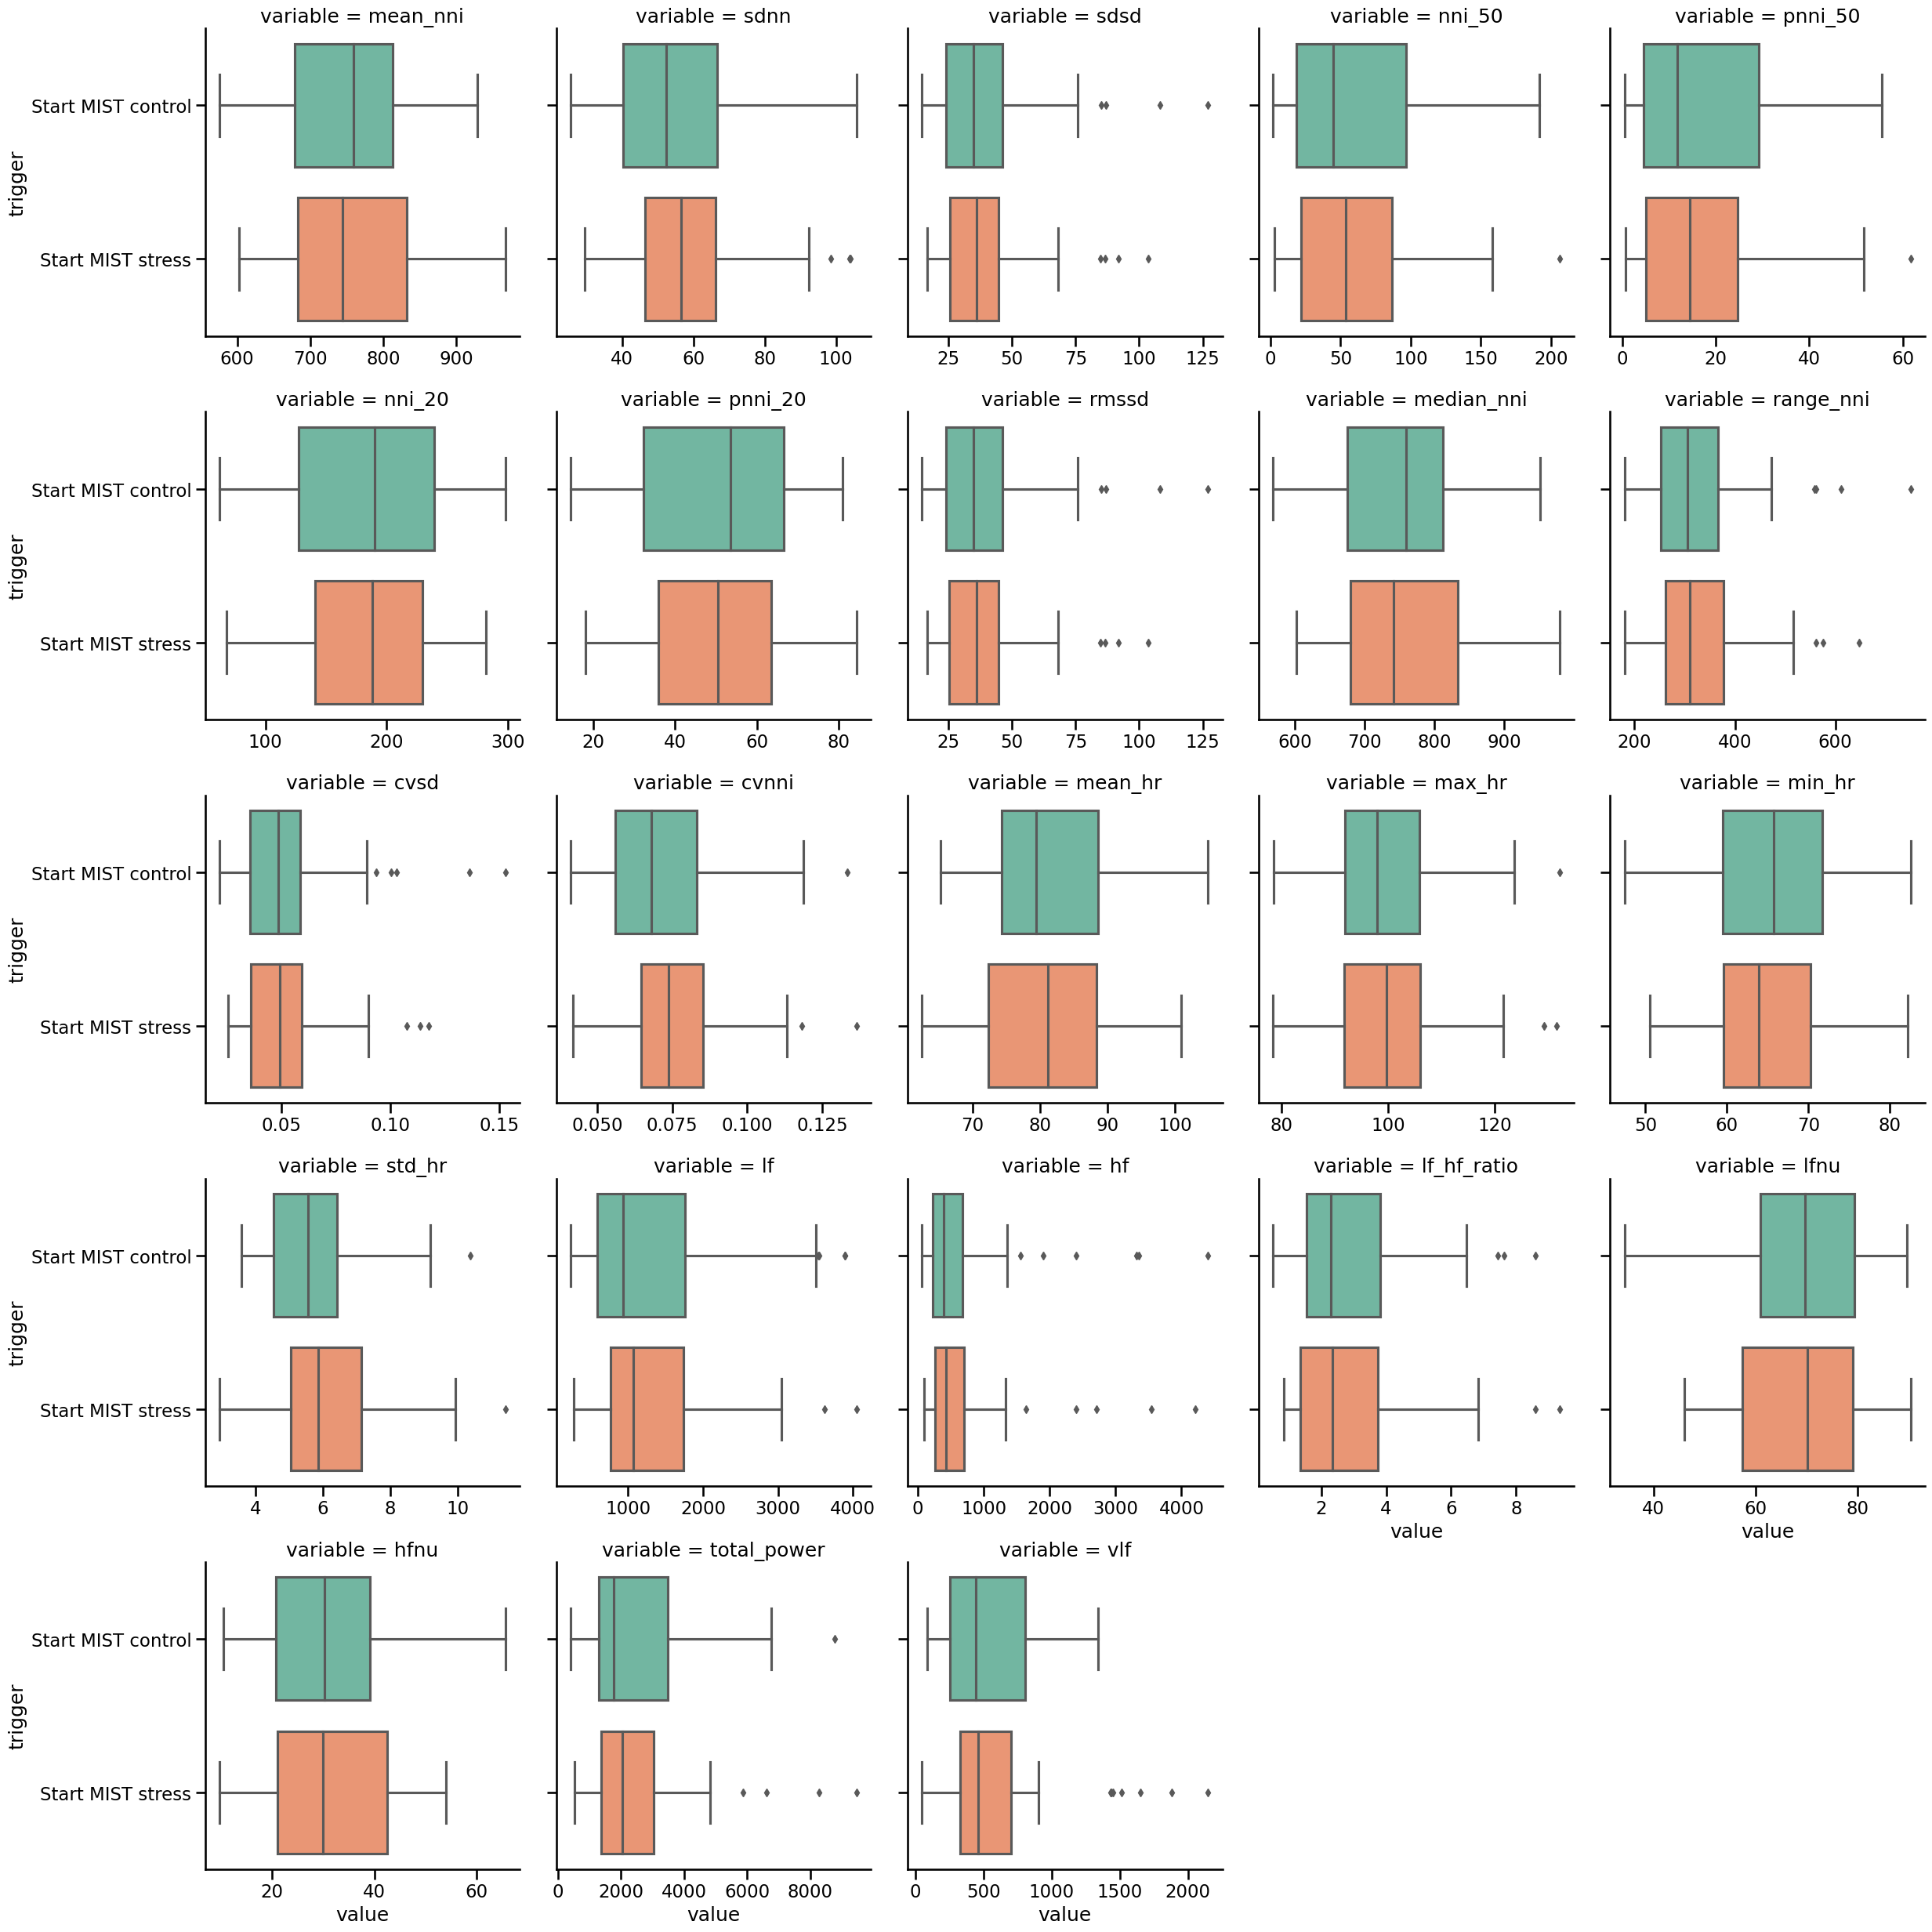

In [29]:
sns.catplot(
    data=df_feat[
        df_feat.trigger.isin(["Start MIST control", "Start MIST stress"])
    ].melt(
        id_vars=[
            "t_start",
            "t_end",
            "patient_id",
            "condition",
            "trigger",
            "duration",
            "duration_s",
        ]
    ),
    kind="box",
    x="value",
    y="trigger",
    aspect=1,
    col="variable",
    col_wrap=5,
    palette="Set2",
    sharex=False,
)


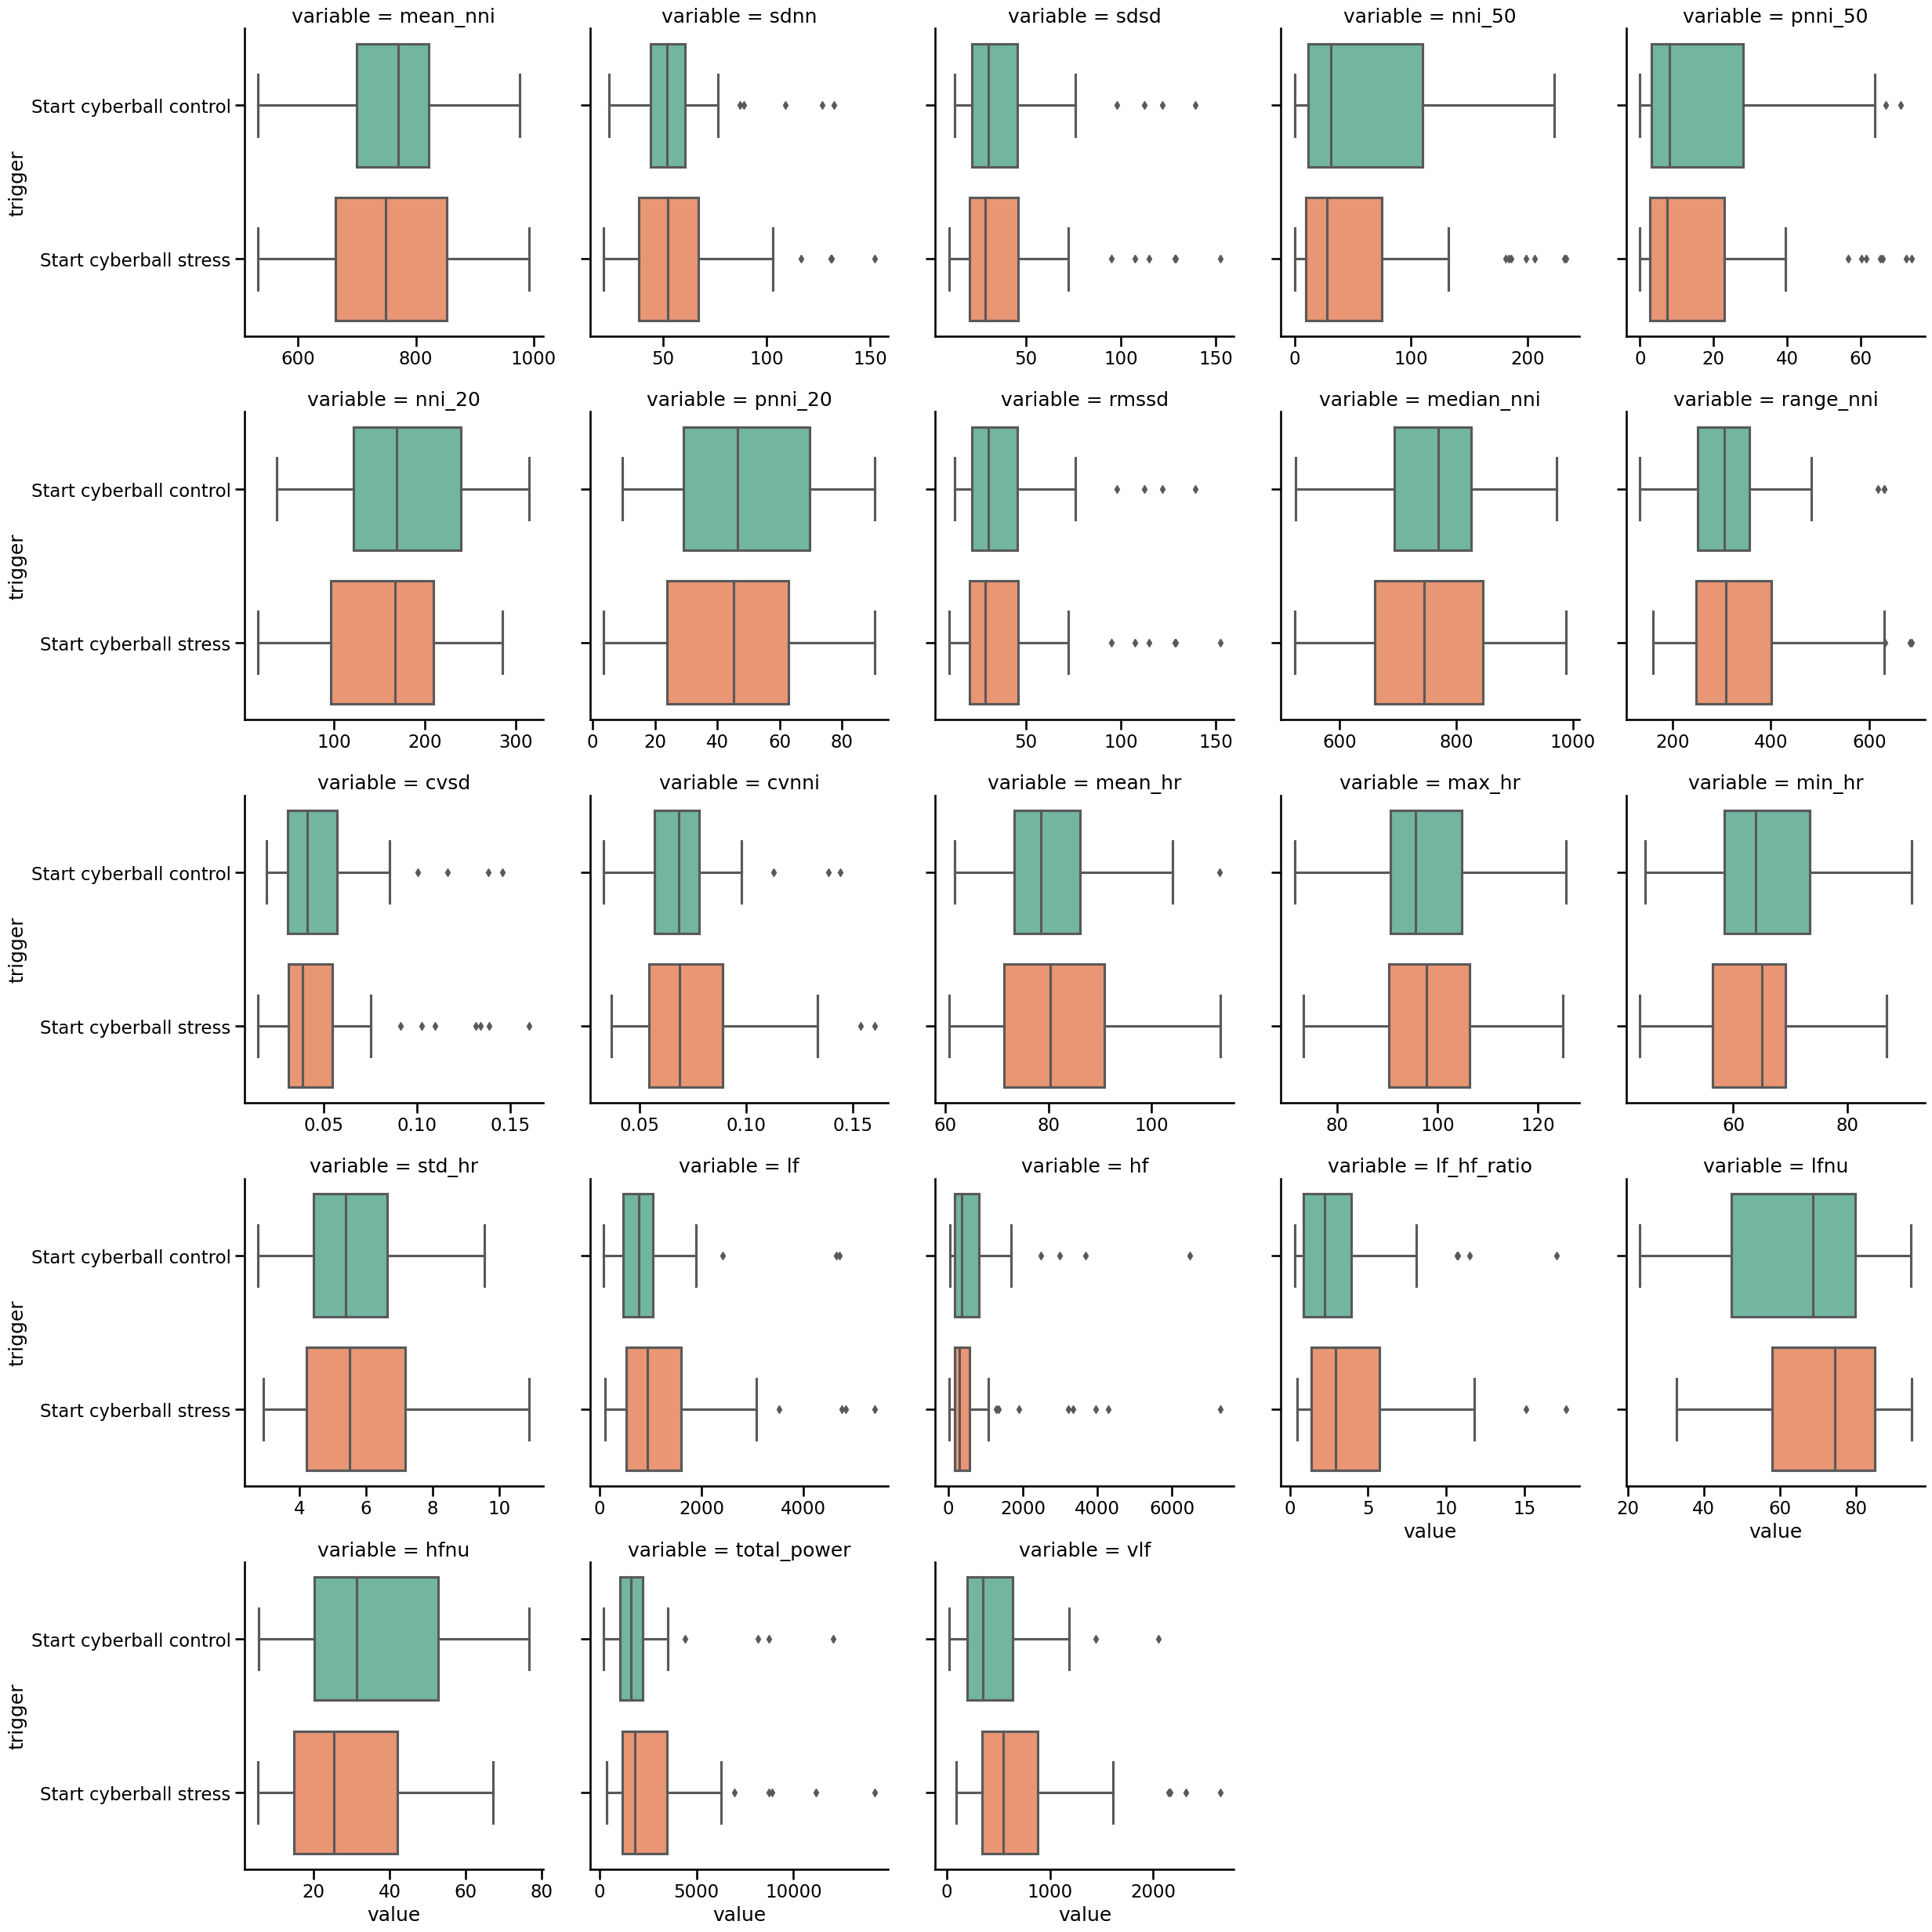

In [30]:
sns.catplot(
    data=df_feat[
        df_feat.trigger.isin(["Start cyberball control", "Start cyberball stress"])
    ].melt(
        id_vars=[
            "t_start",
            "t_end",
            "patient_id",
            "condition",
            "trigger",
            "duration",
            "duration_s",
        ]
    ),
    kind="box",
    x="value",
    y="trigger",
    aspect=1,
    col="variable",
    col_wrap=5,
    palette="Set2",
    sharex=False,
)


In [33]:
df_feat.drop(columns=['duration']).to_parquet('df_rr_feat.parquet')